# CS156 Assignment 1
**Moore’s law & MNIST Digits** | By Korede Akande

## Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn import linear_model, neighbors
from sklearn.metrics import mean_squared_error, r2_score

## Question 1: Moore's Law

Moore's Law states that the number of transistors on a microchip **doubles** every **two years**

**Loading relevant files**

In [2]:
#File containing test benchmarks and speeds
cpu_benchmarks_df = pd.read_csv('benchmarks.csv',low_memory=False)

#File containing test information
test_summary_df = pd.read_csv('summaries.csv',low_memory=False)

**Merging the dataframes together**

Check for duplicate values

In [3]:
print(f"There are {test_summary_df.duplicated('testID').sum()} duplicated testIDs")

There are 0 duplicated testIDs


In [4]:
#Get subset of test_summary df we are interested in and merge df to benchmarks_df on testID
merged_df = pd.merge(cpu_benchmarks_df,test_summary_df[['testID','hwAvail']],how='left',on='testID')
merged_df.head()

,testID,benchName,base,peak,hwAvail
0,cpu95-19990104-03254,101.tomcatv,19.40,27.1,Jan-1999
1,cpu95-19990104-03254,102.swim,27.20,34.8,Jan-1999
2,cpu95-19990104-03254,103.su2cor,10.10,9.98,Jan-1999
3,cpu95-19990104-03254,104.hydro2d,8.58,8.61,Jan-1999
4,cpu95-19990104-03254,107.mgrid,8.94,9.44,Jan-1999


In [5]:
print(f"There are {merged_df.hwAvail.isna().sum()} missing date values")

There are 0 missing date values


### 1. Extract the date and base speed for a benchmark of your choice.
- Chosen benchmark: 454.calculix

In [6]:
#Get the dates and base speeds for given benchmark
benchmark_df = merged_df.query("benchName == '454.calculix'")[['hwAvail','base']].rename(columns = 
                                                                                         {'hwAvail':'date',
                                                                                         'base':'base_speed'})

#Convert date column to datetime object 
benchmark_df.date = pd.to_datetime(benchmark_df.date, format = '%b-%Y')

benchmark_df

,date,base_speed
45851,1997-04-01,0.997
45892,2006-01-01,5.860
45921,2006-05-01,9.710
45938,2005-06-01,9.640
45979,2005-09-01,6.650
...,...,...
136861,2011-05-01,29.500
136890,2011-05-01,38.400
136919,2011-09-01,40.900
136948,2011-05-01,32.000


### 2. Plot the data in a semi-log plot

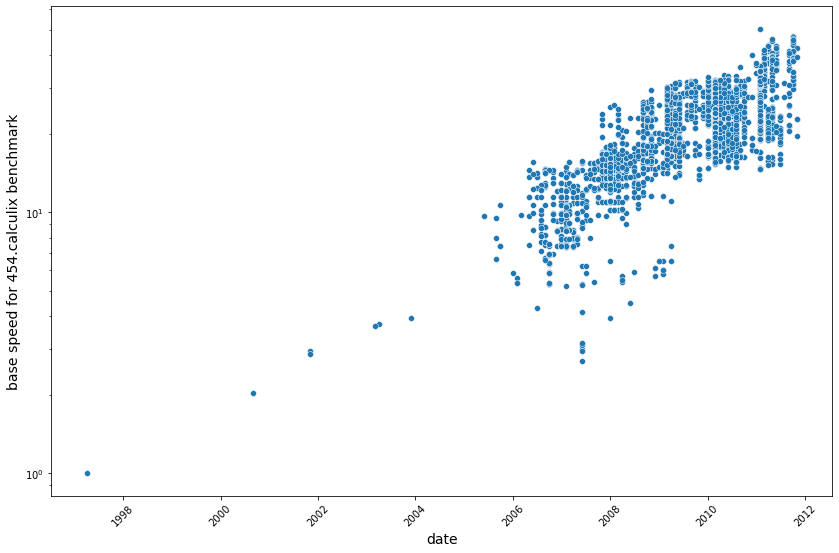

In [9]:
plt.figure(figsize=(14,9))
sns.scatterplot(data= benchmark_df, x='date',y='base_speed')
plt.yscale('log')
plt.xlabel('date', fontsize=14)
plt.ylabel('base speed for 454.calculix benchmark',fontsize=14)
plt.xticks(rotation=45)
plt.show()

### 3. Train a linear model to fit the plot above

To get the data to match the plot above, we must linearize the underlying exponential relationship between the two variables. This can be achieved by taking the logarithm of the base speeds. I take $log_2$ given Moore's law states the base speed would **double** every two years.

In [418]:
#To convert the dates from datetime to numbers, we calculate the months from the first day
#This also allows for easy interpretation of the results
X = np.array([(x-min(benchmark_df.date))/np.timedelta64(1,"M") for x in benchmark_df.date]).reshape(-1, 1)

#Log Base 2 of base speeds
y = np.log2(benchmark_df.base_speed.values)

#Split the data into training/testing sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Create linear regression object
regr = linear_model.LinearRegression()

# Train the model to fit data
regr.fit(X_train, y_train)

# Make predictions using the test set
y_pred = regr.predict(X_test)

In [419]:
#The slope
print('Slope: ', round(regr.coef_[0],4))

#The intercept
print('\nIntercept: ', regr.intercept_)

# The root mean squared error
print('\nRoot Mean squared error: %.2f GHz \n' % (mean_squared_error(y_test, y_pred))**0.5)

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination (R²): %.2f ' % r2_score(y_test, y_pred))

Slope:  0.0268

Intercept:  0.35538857108916444

Root Mean squared error: 0.38 GHz 

Coefficient of determination (R²): 0.62 


**Discussion of Regression Results & Metrics**

We note that we get an R²=0.62, telling us that the model fit the data reasonably well. We also note a fairly low RMSE of 0.38. All these are good signs that our model did a fairly decent job fitting the data.

### 4. How well is Moore’s law holding up?

**Plotting the regression line**

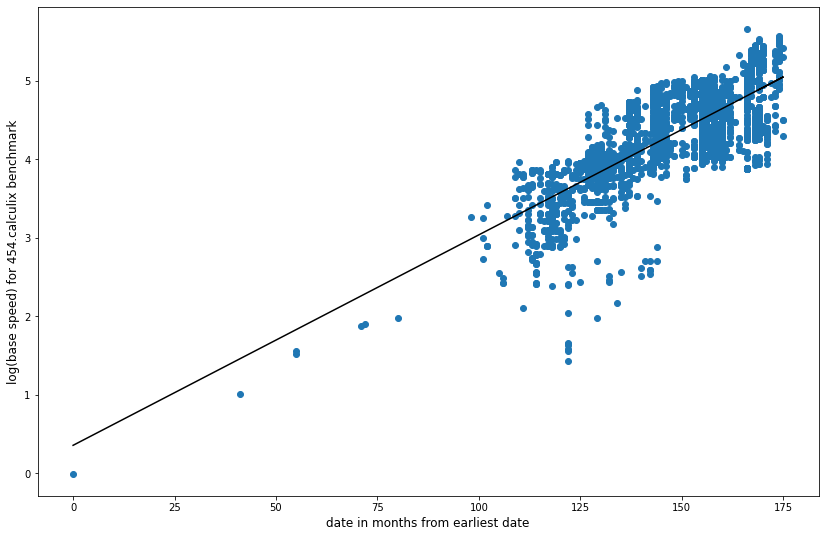

In [420]:
plt.figure(figsize=(14,9))
plt.scatter(X,y)
plt.plot(X,regr.predict(X), color='k')
plt.xlabel('date in months from earliest date', fontsize=12)
plt.ylabel('log(base speed) for 454.calculix benchmark',fontsize=12)
plt.show()

To determine how well Moore's law is holding up, we need to calculate the doubling time from our model.

The formula to do is given thus:

Doubling time = $\frac{ln(2)}{m}$, where $m$ is the slope of our model and $ln(2)$ is the actually time needed to double

∴ Doubling time = $\frac{ln(2)}{0.027} \approx 25.67 months$

This tells us that the base speed doubles approximately every 2.14 years, thus indicating that Moore's law (which says the speed doubles every 2 years) does in fact hold up in this scenario.

## Question 2: MNIST Digits

### 1. Using Scikit.learn, load the MNIST digits

In [422]:
from sklearn.datasets import load_digits
digits = load_digits()

### 2. Plot some of the examples

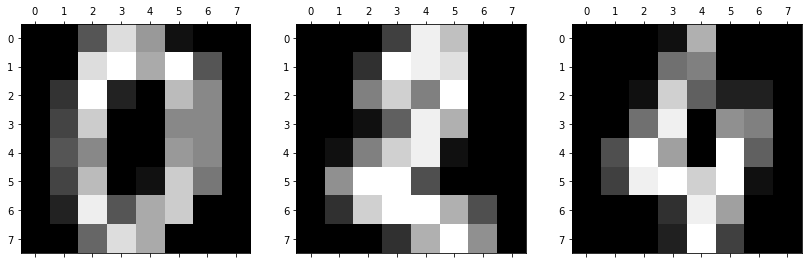

In [427]:
fig, axs = plt.subplots(1, 3, figsize=(14,9))
for i in range(0,6,2):
    axs[int((i/2))].matshow(digits.images[i], cmap = plt.cm.gray) 
plt.show() 

### 3. Choose two digit classes (e.g 7s and 3s) , and train a k-nearest neighbor classifier.

**Digits chosen:** 3 and 8

In [428]:
#List to store the images and their target values
img_data = []
target_vals = []

#Iterate through all the images
for i in range(len(digits.target)):
    
    #We pick digit class 3 and 8
    if digits.target[i] in [3,8]:
        
        #Append the target class and the image
        target_vals.append(digits.target[i])
        img_data.append(digits.data[i])

**Training the kNN classifier**

I also use cross-validation on the training set to determine the optimal k

In [429]:
from sklearn.model_selection import cross_val_score

#Split the data into training/testing sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(img_data, target_vals, test_size=0.2, random_state=54)

#List to store the average accuracy values for different k values
accuracy_scores = []

for k in range(1,6):
    
    #Train a nearest neighbour classifier with chosen k 
    clf = neighbors.KNeighborsClassifier(k, weights= 'uniform')
    
    #Get the scores from the cross validation
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    
    #Compute the average score for the chosen k values
    accuracy_scores.append((k,scores.mean()))
    

print(accuracy_scores)

[(1, 1.0), (2, 0.9894736842105264), (3, 0.9964912280701753), (4, 0.9964912280701753), (5, 0.9964912280701753)]


**Selecting a k value**

Although 1 predicts the test data perfectly, I opt against selecting it for two reasons:
- A k value of 1 will likely result in a model that is not robust, one that is easily swayed by a single nearest neighbours decision
- With an accuracy of 1, I fear the model might have overfit the data

I instead go for a **k = 3**, this value is not too low (hence, more robust to outliers and non-representative nearest neighbours) and not too high

### 4. Report your error rates on a held out part of the data.

**Evaluating on the test set**

In [432]:
#Training a model with k=3
clf = neighbors.KNeighborsClassifier(3, weights= 'uniform')

#Fitting the model on the training data
clf.fit(X_train,y_train)

#Predicting classes from the test set
print(f"Test Set Classification Error rate = {round((1-clf.score(X_test,y_test))*100,3)}%")

Test Set Classification Error rate = 2.778%


**Discussion of Classification Results**

The kNN model does a really good job differentiating 3s from 8s, having an error rate of about 2.8% (thus, accuracy of 97.2%).